In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
valve_states = np.load("valve_states.npy")

In [31]:
class ValveModel:
    def __init__(self, sample_rate=10000, acquisition_time=6, pre_sequence_time=0.5, post_sequence_time=0.5, pulse_time=1, back_valve_delay=0.05, interval_time=3):   
        self.sample_rate = sample_rate
        self.acquisition_samples = int(acquisition_time * self.sample_rate)
        self.interval_time = interval_time
        self.back_valve_delay_samples = int(back_valve_delay * self.sample_rate)
        self.pre_sequence_samples = int(pre_sequence_time * self.sample_rate)
        self.post_sequence_samles = int(post_sequence_time * self.sample_rate)
        self.pulse_samples = int(pulse_time * self.sample_rate)
        self.cycle_samples = int(0.004 * self.sample_rate)
        self.ttl_bit_samples = int(0.004 * self.sample_rate)
        self.all_clean_air_valves = [0, 1, 8, 9]
        # self.valves = nidaqmx.Task()
        # self.ai = nidaqmx.Task()
        # self.valves.do_channels.add_do_chan("Front_valves/port0/line0:15, Back_valves/port0/line0:7, Back_valves/port0/line16:23, Front_valves/port0/line16", line_grouping=nidaqmx.constants.LineGrouping.CHAN_PER_LINE)
        # self.ai.ai_channels.add_ai_voltage_chan("AI/ai0, AI/ai1, AI/ai2")
        # self.init_clock_and_trigger(self.valves)
        # self.init_clock_and_trigger(self.ai)

    # def __del__(self):
    #     self.valves.close()
    #     self.ai.close()

    def init_clock_and_trigger(self, task):
        task.timing.cfg_samp_clk_timing(self.sample_rate, source="OnboardClock", samps_per_chan=self.acquisition_samples, sample_mode=nidaqmx.constants.AcquisitionType.FINITE)
        # task.triggers.start_trigger.cfg_dig_edge_start_trig("/cDAQ1/PFI0")

    def determine_clean_air_valve(self, odour_valve):
        return {k: (k > 8) * k // 8 * 8 + 1 - k % 2 for k in list(range(2, 8)) + list(range(10, 16))}.get(odour_valve)

    def generate_valve_pattern(self, odour_valves, duty_cycles, label=""):
        valve_states = np.vstack([np.ones((16, self.acquisition_samples), dtype=int), np.zeros((16, self.acquisition_samples), dtype=int), np.ones((1, self.acquisition_samples), dtype=int)])
        clean_air_valves = [self.determine_clean_air_valve(odour_valve) for odour_valve in odour_valves]
        valve_states[self.all_clean_air_valves, :] = 0
        for k in range(len(odour_valves)):
            on_samples = int(self.cycle_samples * duty_cycles[k])
            pulse_pattern = np.concatenate(np.arange(0, self.pulse_samples, self.cycle_samples).reshape(-1, 1) + np.arange(on_samples))
            valve_states[odour_valves[k], pulse_pattern + self.pre_sequence_samples + self.pulse_samples * k] = 0
            valve_states[odour_valves[k] + 16, self.pre_sequence_samples + self.pulse_samples * k + self.back_valve_delay_samples: self.pre_sequence_samples + self.pulse_samples * (k + 1) - self.back_valve_delay_samples] = 1
            valve_states[clean_air_valves[k], pulse_pattern + self.pre_sequence_samples + self.pulse_samples * k] = 1
        # creating a binary code for the label
        bytes_array = np.frombuffer(label.encode(), dtype=np.uint8)
        binary_codes = np.unpackbits(bytes_array)
        binary_codes = binary_codes[:len(label) * 7].reshape(-1, 7).reshape(-1)
        true_indices = np.where(binary_codes)[0] + 2
        true_indices = np.hstack([0, true_indices])
        ttl_pattern = (true_indices[:, None] * self.ttl_bit_samples + np.arange(self.ttl_bit_samples)).ravel() + self.pre_sequence_samples
        valve_states[32, ttl_pattern] = 0
        return valve_states.astype(bool)

    def play_valve_sequence(self, odour_valves, duty_cycles, label):
        valve_states = self.generate_valve_pattern(odour_valves, duty_cycles, label=label)
        self.valves.write(valve_states)
        self.valves.start()
        traces = self.ai.read(number_of_samples_per_channel=self.acquisition_samples)
        self.valves.wait_until_done(timeout=20)
        self.valves.stop()
        self.valves.out_stream.regen_mode = nidaqmx.constants.RegenerationMode.DONT_ALLOW_REGENERATION
        self.valves.out_stream.regen_mode = nidaqmx.constants.RegenerationMode.ALLOW_REGENERATION
        return np.array(traces) * 0.8949 - 1.1644

valve_model = ValveModel()

valve_states = valve_model.generate_valve_pattern([2,5,4,3],[0.5,1,1,1], "Test")

valve_model.generate_valve_pattern([3,4,5,6], [1,1,1,1], label="")

C:\Users\kollom\AppData\Local\Temp\ipykernel_1380\1065298175.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


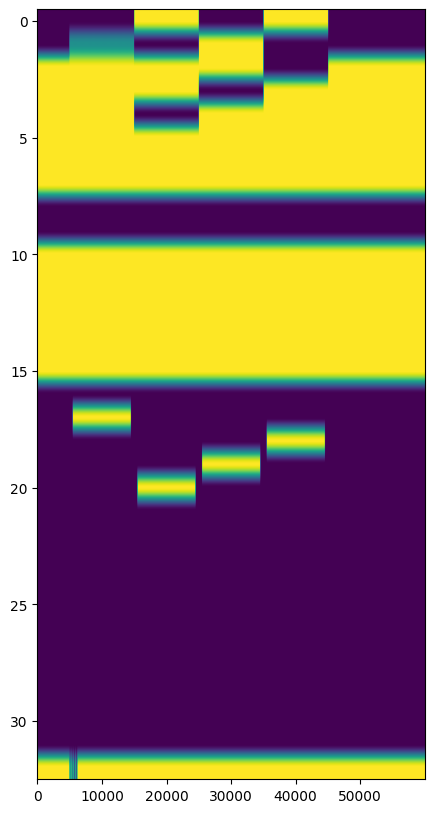

In [32]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
ax.imshow(valve_states, aspect="auto")
fig.show()